In [1]:
from CartPole import *
import numpy as np
import random

In [2]:
def kernel(X,Xi,sigma):
    K = np.zeros((X.shape[0],Xi.shape[0]))
    dim = X.shape[1]
    for i,x in enumerate(X):
        for j,xi in enumerate(Xi):
            sum = 0
            for k in range(dim):
                if k == 2:
                    sum += 1.0*np.sin((x[k]-xi[k])/2)**2/sigma[k]**2
                else:
                    sum += 1.0*(x[k]-xi[k])**2/sigma[k]**2
            K[i,j] = np.exp(-0.5*sum)
    return K

In [3]:
def fit(K_NM,K_MM,lam,Y):
    """return coefficients for each of the dimensions"""
    K_MN = np.transpose(K_NM)
    A = np.matmul(K_MN,K_NM) + lam * K_MM
    B = np.matmul(K_MN,Y)
    alpha = np.linalg.lstsq(A,B)[0]
    return alpha

In [4]:
def predict(X,XM,sigma,alpha):
    K_MN = kernel(X,XM,sigma)
    return np.matmul(K_MN,alpha)

In [5]:
def l(X,sigma):
    """X: state vector"""
    sum = 0
    for i,x in enumerate(X):
        sum += -0.5*np.linalg.norm(x)**2/sigma[i]**2
    return 1.0-np.exp(sum)

In [6]:
N = 1000 # NO of datapoints
M = 640 # NO of data locations for basis function
lam = 10**(-4) # variance of data noise
cartpole1 = CartPole()
X = []
Y = []
for i in range(N):
    x = random.uniform(-5,5)
    x_dot = random.uniform(-10,10)
    theta = random.uniform(-np.pi,np.pi)
    theta_dot = random.uniform(-15,15)
    act = random.uniform(-20,20)
    Xn = np.array([x,x_dot,theta,theta_dot,act])
    X.append(Xn)
    cartpole1.setState(Xn[:-1])
    cartpole1.performAction(action=Xn[-1])
    Xn_1 = np.array(cartpole1.getState())
    Y.append(Xn_1-Xn[:-1])
X = np.array(X)
Y = np.array(Y)

In [31]:
M_ind = random.sample(range(N),M)
XM = np.array([X[ind] for ind in M_ind])
sigma = [np.std(X[:,i]) for i in range(X.shape[1])]
K_NM = kernel(X,XM,sigma)
K_MM = kernel(XM,XM,sigma)
alpha = fit(K_NM,K_MM,lam,Y)

<ipython-input-3-354c0fc11cff>:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  alpha = np.linalg.lstsq(A,B)[0]


In [76]:
"""time evolution using perfromAction and model"""
# setting parameters
Xn = np.array([0,0,np.pi,-14.7,0])
z = np.zeros((M,1))
np.append(XM,z,axis=1)

p = np.array([0,0,0,0]) # initialise the p vector
def policy(p,X):
    return np.dot(p,X)


In [91]:
def rollout(max_t,init_state,p,model=None):
    steps = int(max_t/cartpole1.delta_time) # 0.2s per step
    Xn = init_state[:-1]
    Xn_new = Xn
    if model==None:
        cartpole = CartPole()
        X_cartpole = [Xn[:-1]]
        L_model = 0
        for i in range(steps):
            Xn = Xn_new
            # change the action term according to the policy
            cartpole.setState(Xn[:4])
            action = np.dot(p,Xn)
            cartpole.performAction(action)
            cartpole.remap_angle()
            Xn_new = np.array(cartpole.getState())
            X_cartpole.append(Xn_new)
            L_model+=loss(Xn_new)
        return X_cartpole[:-1], L_model
    else:
        X_model = [Xn] 
        L_model = 0
        for i in range(steps):
            Xn = Xn_new
            # change the action term according to the policy
            Xn[-1] = pol(Xn)
            Xn = Xn.reshape(1,Xn.shape[0])
            Yn = predict(Xn,XM,sigma,alpha)
            Yn.resize(Xn.shape)
            Xn_new = Xn + Yn
            Xn_new = np.array(Xn_new[0])
            Xn_new[2] = remap_angle(Xn_new[2])
            X_model.append(Xn_new)
            L_model+=loss(Xn_new[:-1])
        return X_model[:-1], L_model

In [135]:
"""CHANGE INITIAL STATES TO EXPLORE VALUES OF P"""
state1 = np.array([1,3,np.pi,-4,0])
state2 = np.array([0,0,np.pi,-14.7,0])
init_state = state1
X_mode, L_model = rollout(1.5,init_state,p)

In [136]:
"""to plot 1D scans of p -> 4 plots in total"""
p_range = np.linspace(-100,100,100)
p1_scan = np.array([[i,0,0,0] for i in p_range])
p2_scan = np.array([[0,i,0,0] for i in p_range])
p3_scan = np.array([[0,0,i,0] for i in p_range])
p4_scan = np.array([[0,0,0,i] for i in p_range])

In [137]:
def one_dim_scan(p_scan):
    L = []
    for p in p_scan:
        _, L_model = rollout(1.5,init_state,p)
        L.append(L_model)
    return L

In [138]:
L1 = one_dim_scan(p1_scan)
L2 = one_dim_scan(p2_scan)
L3 = one_dim_scan(p3_scan)
L4 = one_dim_scan(p4_scan)

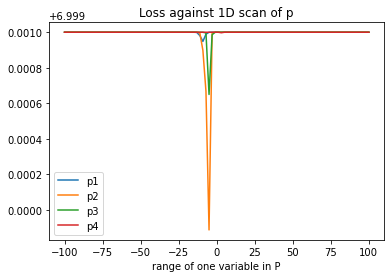

In [139]:
"""plotting"""
plt.plot(p_range, L1, label='p1')
plt.plot(p_range, L2, label='p2')
plt.plot(p_range, L3, label='p3')
plt.plot(p_range, L4, label='p4')
plt.legend()
plt.xlabel('range of one variable in P')
plt.title('Loss against 1D scan of p')
plt.show()

In [141]:
"""to plot 2D contours of p -> 4C2=6 plots in total"""
import matplotlib.tri as tri
p_range = np.linspace(-50,25,100)
p1_scan = np.array([[i,0,0,0] for i in p_range])
p2_scan = np.array([[0,i,0,0] for i in p_range])
p3_scan = np.array([[0,0,i,0] for i in p_range])
p4_scan = np.array([[0,0,0,i] for i in p_range])

In [142]:
def contour_val(scan1,scan2):
    L12 = []
    for s1 in scan1:
        L1 = []
        for s2 in scan2:
            p12 = s1 + s2
            _, l = rollout(1.5,init_state,p12)
            L1.append(l)
        L12.append(L1)
    return np.array(L12)

In [143]:
L12 = contour_val(p1_scan,p2_scan)
L13 = contour_val(p1_scan,p3_scan)
L14 = contour_val(p1_scan,p4_scan)
L23 = contour_val(p2_scan,p3_scan)
L24 = contour_val(p2_scan,p4_scan)
L34 = contour_val(p3_scan,p4_scan)

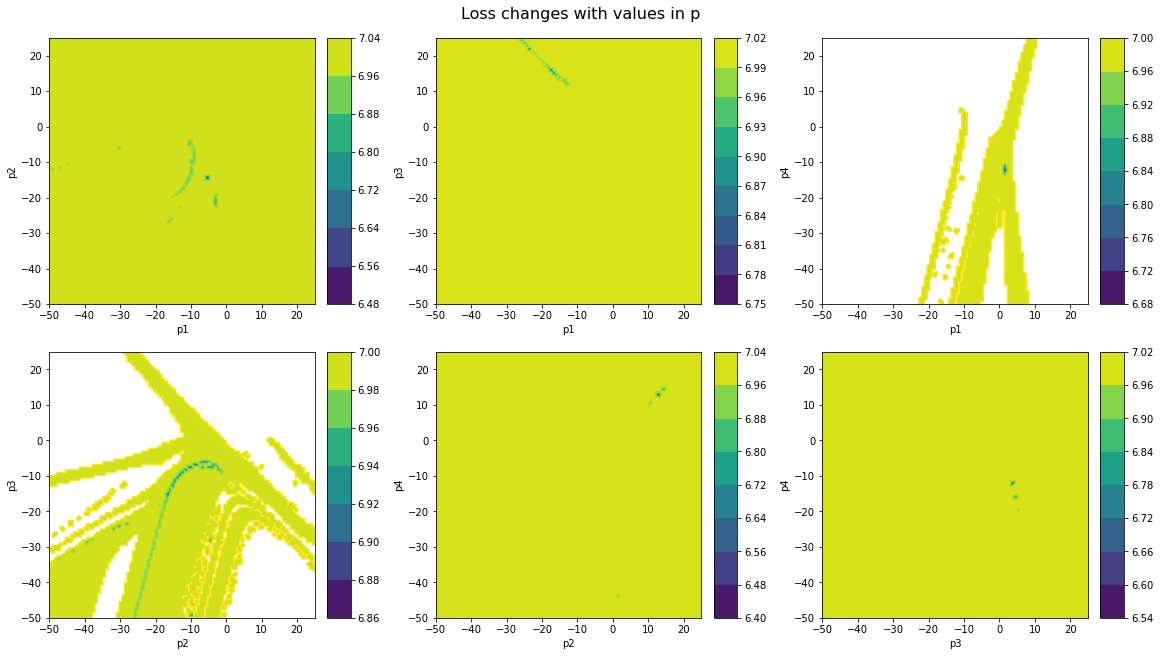

In [144]:
x = p_range
y = p_range

fig, axs = plt.subplots(2,3,figsize=(16,9),constrained_layout=True)
x, y = np.meshgrid(x,y)
triang = tri.Triangulation(x.flatten(), y.flatten())

z = L12
name = ['p1','p2']
cntr1 = axs[0,0].tricontourf(triang, z.flatten())
fig.colorbar(cntr1, ax=axs[0,0])
axs[0,0].tricontour(triang,z.flatten())
axs[0,0].set_xlabel(name[0])
axs[0,0].set_ylabel(name[1])

z = L13
name = ['p1','p3']
cntr2 = axs[0,1].tricontourf(triang, z.flatten())
fig.colorbar(cntr2, ax=axs[0,1])
axs[0,1].tricontour(triang,z.flatten())
axs[0,1].set_xlabel(name[0])
axs[0,1].set_ylabel(name[1])

z = L14
name = ['p1','p4']
cntr5 = axs[0,2].tricontourf(triang, z.flatten())
fig.colorbar(cntr5, ax=axs[0,2])
axs[0,2].tricontour(triang,z.flatten())
axs[0,2].set_xlabel(name[0])
axs[0,2].set_ylabel(name[1])

z = L23
name = ['p2','p3']
cntr3 = axs[1,0].tricontourf(triang, z.flatten())
fig.colorbar(cntr3, ax=axs[1,0])
axs[1,0].tricontour(triang,z.flatten())
axs[1,0].set_xlabel(name[0])
axs[1,0].set_ylabel(name[1])

z = L24
name = ['p2','p4']
cntr4 = axs[1,1].tricontourf(triang, z.flatten())
fig.colorbar(cntr4, ax=axs[1,1])
axs[1,1].tricontour(triang,z.flatten())
axs[1,1].set_xlabel(name[0])
axs[1,1].set_ylabel(name[1])

z = L34
name = ['p3','p4']
cntr6 = axs[1,2].tricontourf(triang, z.flatten())
fig.colorbar(cntr6, ax=axs[1,2])
axs[1,2].tricontour(triang,z.flatten())
axs[1,2].set_xlabel(name[0])
axs[1,2].set_ylabel(name[1])

fig.suptitle('Loss changes with values in p',fontsize=16)

plt.show()

In [155]:
from scipy.optimize import minimize

In [166]:
max_t = 1.5
state1 = np.array([0,0,np.pi,-5,0])
state2 = np.array([0,0,np.pi,-14.7,0])
init_state = state1
def rolloutL(p):
    steps = int(max_t/cartpole1.delta_time) # 0.2s per step
    Xn = init_state[:-1]
    Xn_new = Xn
    cartpole = CartPole()
    X_cartpole = [Xn[:-1]]
    L_model = 0
    for i in range(steps):
        Xn = Xn_new
        # change the action term according to the policy
        cartpole.setState(Xn[:4])
        action = np.dot(p,Xn)
        cartpole.performAction(action)
        cartpole.remap_angle()
        Xn_new = np.array(cartpole.getState())
        X_cartpole.append(Xn_new)
        L_model+=loss(Xn_new)
    return L_model


In [167]:
p = np.array([-15,-10,-5,0])
res = minimize(rolloutL,p,method='Nelder-Mead')
res.x

array([ 1.35752353, -7.96872282, -2.18362097,  1.52580352])

In [172]:
def modelL(p):
    steps = int(max_t/cartpole1.delta_time) # 0.2s per step
    Xn = init_state[:-1]
    Xn_new = Xn
    L_model = 0
    for i in range(steps):
        Xn = Xn_new
        # change the action term according to the policy
        Xn[-1] = np.dot(p,Xn)
        Xn = Xn.reshape(1,Xn.shape[0])
        Yn = predict(Xn,XM,sigma,alpha)
        Yn.resize(Xn.shape)
        Xn_new = Xn + Yn
        Xn_new = np.array(Xn_new[0])
        Xn_new[2] = remap_angle(Xn_new[2])
        L_model+=loss(Xn_new[:-1])
    return L_model

In [174]:
p = np.array([-15,-10,-5,0])
res = minimize(modelL,p,method='Nelder-Mead')
res.x

array([-15., -10.,  -5.,   0.])